In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions


print(tf.__version__)

2.12.0


# Loading Dataset

In [56]:
dataset = {
             "train_data" : "/content/drive/MyDrive/Golden/Dataset/training_set",
             "valid_data" : "/content/drive/MyDrive/Golden/Dataset/test_set",

          }

all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()

train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))

lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])

In [57]:
valid_df , test_df = train_test_split(valid_df ,  train_size= 0.7 , shuffle=True, random_state=124)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [58]:
print("----------Train-------------")
print(train_df[["imgpath", "labels", "encoded_labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels", "encoded_labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels", "encoded_labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath labels  encoded_labels
0  /content/drive/MyDrive/Golden/Dataset/training...   dogs               1
1  /content/drive/MyDrive/Golden/Dataset/training...   dogs               1
2  /content/drive/MyDrive/Golden/Dataset/training...   dogs               1
3  /content/drive/MyDrive/Golden/Dataset/training...   dogs               1
4  /content/drive/MyDrive/Golden/Dataset/training...   dogs               1
(8007, 3)
--------Validation----------
                                             imgpath labels  encoded_labels
0  /content/drive/MyDrive/Golden/Dataset/test_set...   dogs               1
1  /content/drive/MyDrive/Golden/Dataset/test_set...   cats               0
2  /content/drive/MyDrive/Golden/Dataset/test_set...   dogs               1
3  /content/drive/MyDrive/Golden/Dataset/test_set...   cats               0
4  /content/drive/MyDrive/Golden/Dataset/test_set...   cats               0
(1417, 3)
----------

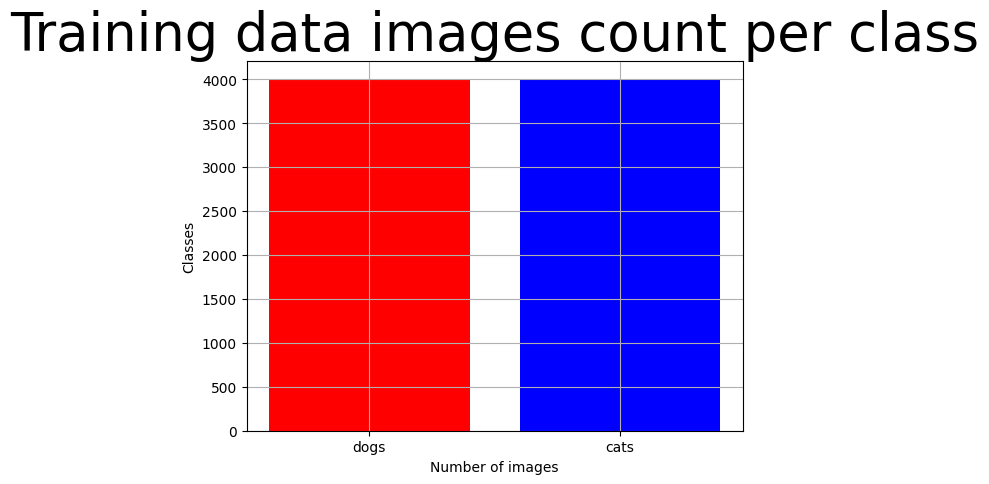

In [59]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images')
plt.ylabel('Classes')
plt.bar(index,label, color = ['red', 'blue'])
plt.grid(True)
plt.show()

# Show sample from data

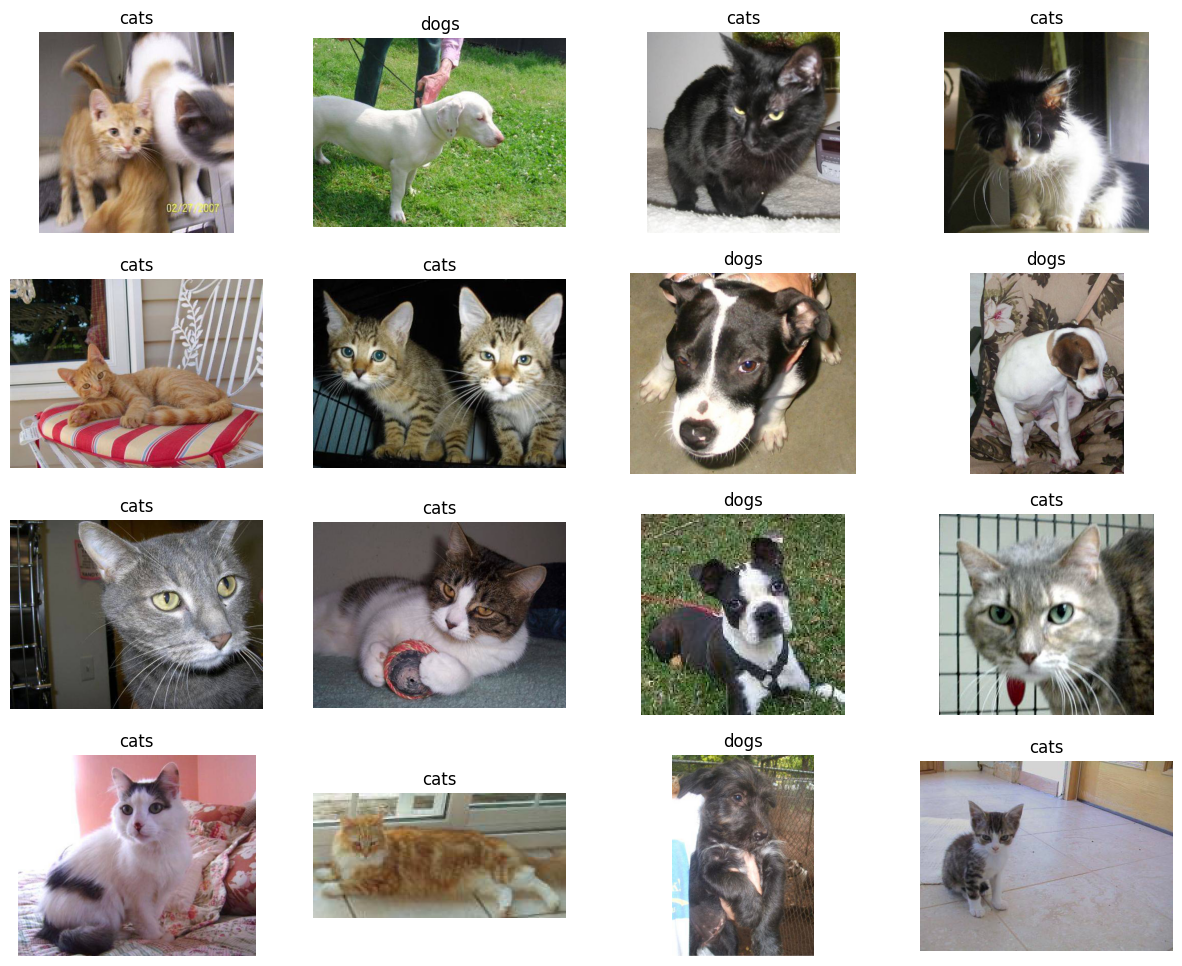

In [60]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# Creating Dataloaders

In [61]:
BATCH_SIZE = 25
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8005 validated image filenames belonging to 2 classes.
Found 1416 validated image filenames belonging to 2 classes.
Found 607 validated image filenames belonging to 2 classes.


# Model use trasnfer learning

In [62]:
# Load the pretained model
# Use VGG19
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

## Augmentate Data

In [63]:
# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
], name='AugmentationLayer')


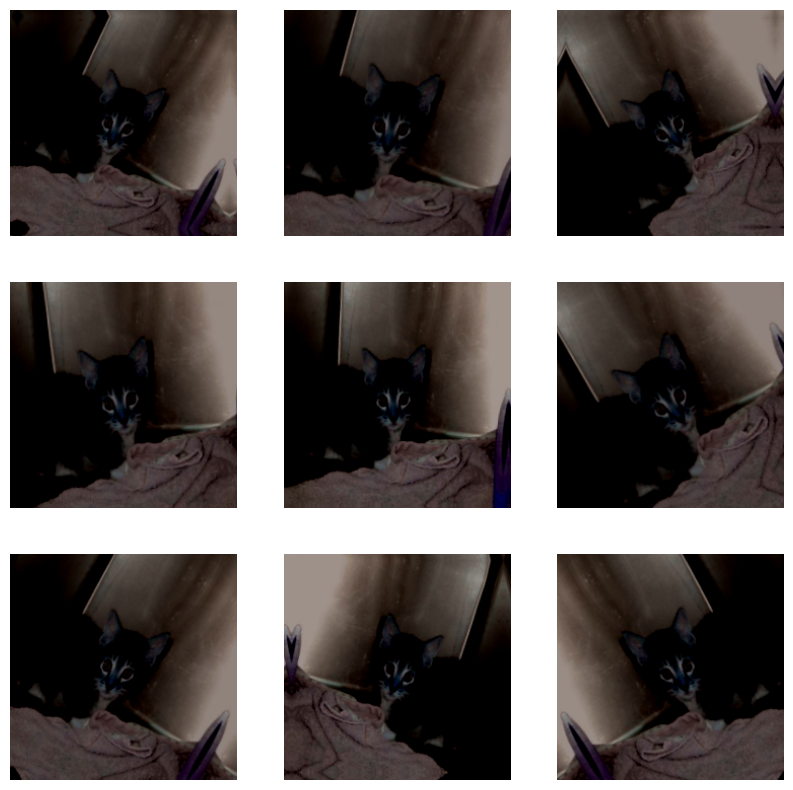

In [64]:
sample = next(train_images)
plt.figure(figsize=(10, 10))
first_image = sample[0][0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment(tf.expand_dims(first_image, 0))
    augmented_image_normalized = augmented_image[0].numpy() / 255.0  # Normalize the image data
    augmented_image_normalized = np.array(augmented_image_normalized, dtype=np.float32)  # Convert dtype to float32
    plt.imshow(augmented_image_normalized)
    plt.axis('off')
plt.show()

## Build model

In [65]:
num_classes = len(set(train_images.classes))

inputs = layers.Input(shape = (224,224,3), name='inputLayer')


x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)



x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)


#Last player
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                           

## Train model

In [66]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=4,
    callbacks=[EarlyStopping(monitor = "val_loss",patience = 3, restore_best_weights = True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')]
)

Epoch 1/4
321/321 [==============================] - 724s 2s/step - loss: 0.3993 - accuracy: 0.8222 - val_loss: 0.1431 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 2/4
321/321 [==============================] - 55s 171ms/step - loss: 0.3142 - accuracy: 0.8541 - val_loss: 0.1020 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 3/4
321/321 [==============================] - 55s 172ms/step - loss: 0.3050 - accuracy: 0.8611 - val_loss: 0.2161 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 4/4
321/321 [==============================] - 54s 167ms/step - loss: 0.2953 - accuracy: 0.8696 - val_loss: 0.1309 - val_accuracy: 0.9668 - lr: 0.0010


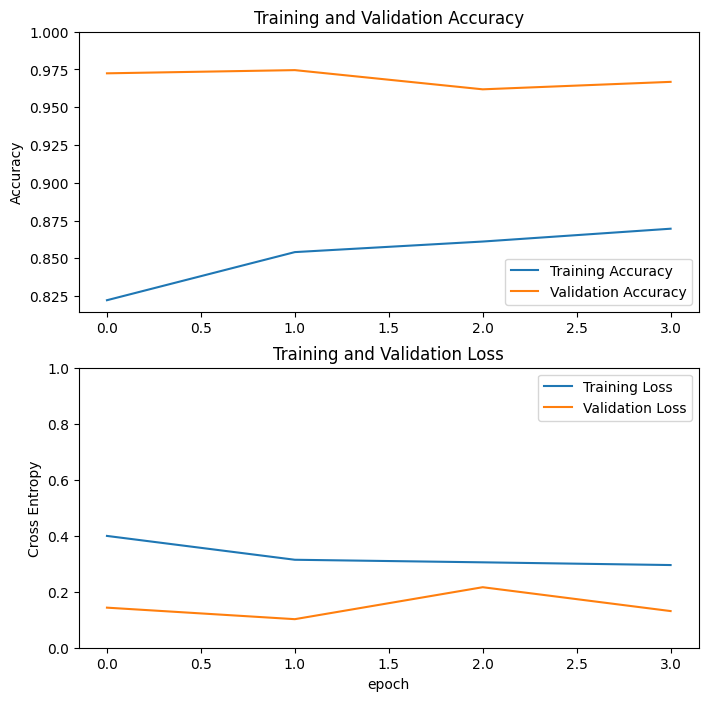

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Training : Fine Tuning

In [68]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)


input_4 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True


In [69]:
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, None, None, None)  0        
 al)                                                             
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                           

In [70]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=4,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

Epoch 1/4
321/321 [==============================] - 87s 240ms/step - loss: 0.2174 - accuracy: 0.9053 - val_loss: 0.1743 - val_accuracy: 0.9732 - lr: 1.0000e-05
Epoch 2/4
321/321 [==============================] - 73s 229ms/step - loss: 0.1624 - accuracy: 0.9290 - val_loss: 0.0653 - val_accuracy: 0.9809 - lr: 1.0000e-05
Epoch 3/4
321/321 [==============================] - 75s 233ms/step - loss: 0.1409 - accuracy: 0.9413 - val_loss: 0.0794 - val_accuracy: 0.9781 - lr: 1.0000e-05
Epoch 4/4
321/321 [==============================] - 74s 230ms/step - loss: 0.1132 - accuracy: 0.9565 - val_loss: 0.0623 - val_accuracy: 0.9823 - lr: 1.0000e-05


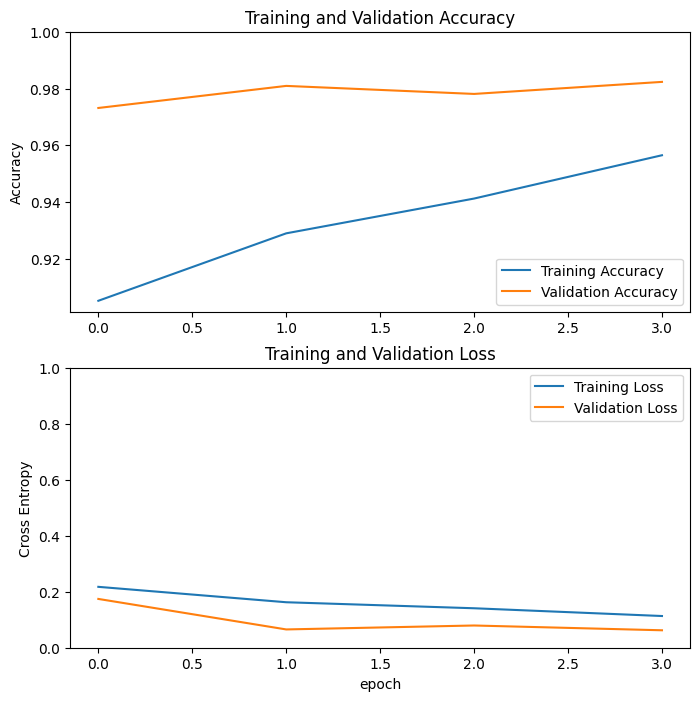

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [72]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.07214
Test Accuracy: 97.69%


## F1 Score / Recall / Precision

In [73]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

25/25 [==============================] - 3s 125ms/step
F1 Score: 0.9768497330282226
              precision    recall  f1-score   support

        cats       0.97      0.98      0.98       283
        dogs       0.98      0.97      0.98       324

    accuracy                           0.98       607
   macro avg       0.98      0.98      0.98       607
weighted avg       0.98      0.98      0.98       607



## Get Predictions

In [74]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

25/25 [==============================] - 4s 155ms/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Prediction Probability
0,0,0,cats,0,cats,0.999984
1,1,0,cats,0,cats,0.999999
2,2,1,dogs,1,dogs,1.000000
3,3,0,cats,0,cats,0.999975
4,4,0,cats,0,cats,0.999973
5,5,1,dogs,1,dogs,0.999984
6,6,0,cats,0,cats,1.000000
7,7,0,cats,0,cats,0.999387


## Confusion Matrics and Classification Report

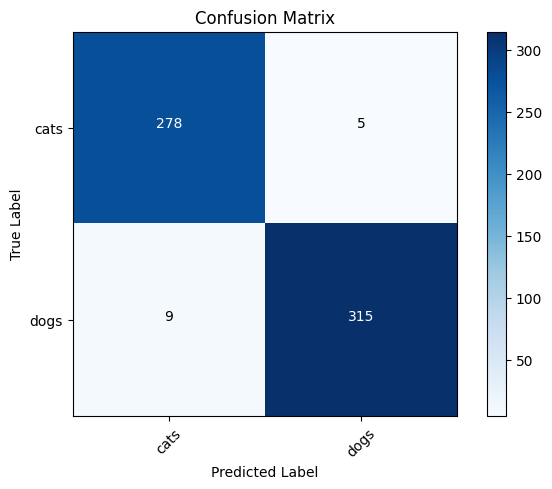

In [75]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


plt.show()

In [88]:
def predict_picture(image_path):
  class_names = {0: 'Cat', 1: 'Dog'}

  # Load the image using PIL's Image module
  img = Image.open(image_path).convert('RGB')
  img = img.resize((224, 224))  # Resize the image if needed

  # Convert the image to an array
  img_array = np.array(img)

  # Preprocess the image using VGG19's preprocess_input function
  preprocessed_img = preprocess_input(img_array)

  # Reshape the image to match the expected input shape of the VGG16 model
  preprocessed_img = np.expand_dims(preprocessed_img, axis=0)

  # Predict the image
  prediction = model.predict(preprocessed_img)
  index = np.argmax(prediction)
  class_name = class_names[index]
  confidence_score = prediction[0][index]

  # Display the top predictions
  print(f"Image Category: {class_name}")
  print(f"Confidence Score: {confidence_score:.4f}")


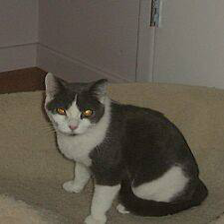

In [112]:
image_path = '/content/drive/MyDrive/Golden/Dataset/test_set/cats/cat.4555.jpg'
img = Image.open(image_path).convert('RGB')
img = img.resize((224, 224))
img

In [113]:
predict_picture(image_path)

1/1 [==============================] - 0s 35ms/step
Image Category: Cat
Confidence Score: 1.0000


# Save model

In [111]:
model.save('/content/drive/MyDrive/Golden/model.h5')